In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 24: Monthly Rebalancing Sprint (v2 - Refined)
# Notebook: 24_monthly_rebalancing_sprint_v2.ipynb
#
# Objective:
#   To execute a refined, 5-day sprint to test the hypothesis that a monthly
#   rebalancing frequency, combined with an optimized four-factor stack, can
#   achieve a Sharpe Ratio of >= 0.70, creating a viable candidate for our
#   final production model.
# ============================================================================
#
# --- STRATEGIC DIRECTIVE & ALIGNMENT ---
#
# This notebook implements the refined strategic directive on monthly rebalancing.
# It incorporates critical feedback to de-risk the experiment and enhance its
# methodological rigor. Key refinements include:
#
# 1.  **Smarter Execution Timing:** Rebalancing is shifted to T+2 after month-end
#     to avoid operational risks associated with month-end liquidity crowding.
# 2.  **Constrained Optimization:** The factor weight optimizer will be constrained
#     to ensure Value remains a core component of the strategy (weight >= 30%).
# 3.  **Realistic Cost Model:** A non-linear transaction cost model that accounts
#     for market impact will be implemented.
# 4.  **Robust Universe Construction:** A trading-day coverage filter will be added
#     to the monthly universe construction to guard against stale liquidity data.
#
# --- PRIMARY RESEARCH QUESTION ---
#
# Can a monthly rebalanced, dynamically weighted four-factor composite (V, Q,
# PosMom, Rev) with a 15% volatility target achieve a Sharpe Ratio in the
# 0.70-0.75 range and a Net CAGR in the 10-11% range over the full 2016-2025 period?
#
# --- METHODOLOGY: THE REFINED 5-DAY SPRINT PLAN ---
#
# This notebook will follow the refined implementation checklist:
#
# 1.  **Day 1 (Engine Upgrade):**
#     -   Create `PortfolioEngine_v4_0` with a `rebalance_freq='M'` flag and
#       T+2 rebalance date logic.
#     -   Implement the enhanced, non-linear transaction cost model.
#
# 2.  **Day 2 (Signal & Optimizer Integration):**
#     -   Integrate the full four-factor signal stack (V, Q, PosMom, Rev).
#     -   Implement a constrained Bayesian optimizer for factor weights.
#
# 3.  **Day 3 (Smoke Test):**
#     -   Run a `Value-only` strategy on the monthly schedule to validate the
#       engine and quantify the turnover/cost impact versus the quarterly baseline.
#
# 4.  **Day 4 (Full Run):**
#     -   Execute the full, four-factor composite strategy with the monthly
#       rebalancing, optimized weights, and 15% volatility target.
#
# 5.  **Day 5 (Analysis & Verdict):**
#     -   Directly compare the final monthly tearsheet against the quarterly
#       baseline, including a cost-adjusted information ratio and slippage
#       stress test.
#     -   Formulate a final Go/No-Go verdict for the Investment Committee.
#
# --- SUCCESS CRITERIA ---
#
# The monthly rebalancing approach will be deemed successful if it delivers:
#
#   -   **Sharpe Ratio:** >= 0.70
#   -   **Maximum Drawdown:** <= -40%
#   -   **Net CAGR:** >= 10%
#

In [ ]:
# ============================================================================
# DAY 1 (ENGINE UPGRADE): MONTHLY FREQUENCY & NON-LINEAR COSTS
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
from typing import Dict, List, Optional

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
import yaml
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
try:
    project_root = Path.cwd().parent.parent.parent
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    from production.universe.constructors import get_liquid_universe_dataframe
    print("✅ Successfully imported production modules.")
except Exception as e:
    print(f"❌ ERROR during module import: {e}")

# --- Unified Configuration Block ---
print("\n⚙️  Initializing unified configuration block for the sprint...")
BASE_CONFIG = {
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "strategy_version_db": "qvm_v2.0_enhanced",
    # Transaction costs are now handled by the new model, not a flat bps rate
}
print("✅ Base configuration defined.")

# --- Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11})
print("✅ Visualization settings configured.")

# --- Data Loading Function ---
def load_all_data(config):
    print("\n📂 Loading all raw data...")
    engine = create_engine(f"mysql+pymysql://{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['username']}:{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['password']}@{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['host']}/{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['schema_name']}")
    db_params = {'start_date': "2016-01-01", 'end_date': config['backtest_end_date'], 'strategy_version': config['strategy_version_db']}
    factor_data_raw = pd.read_sql(text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version"), engine, params=db_params, parse_dates=['date'])
    price_data_raw = pd.read_sql(text("SELECT date, ticker, close, total_value FROM equity_history WHERE date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    benchmark_data_raw = pd.read_sql(text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date"), engine, params=db_params, parse_dates=['date'])
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    daily_adtv_matrix = price_data_raw.pivot(index='date', columns='ticker', values='total_value')
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    print("✅ All data loaded and prepared.")
    return factor_data_raw, daily_returns_matrix, daily_adtv_matrix, benchmark_returns, engine

# --- PORTFOLIO ENGINE v4.0 (MONTHLY REBALANCE & NON-LINEAR COSTS) ---
class PortfolioEngine_v4_0:
    """
    Version 4.0 of our backtesting engine.
    This version implements the Day 1 upgrades for the monthly rebalancing sprint:
        1. Flexible rebalancing frequency ('Q' or 'M') with T+2 logic.
        2. A non-linear transaction cost model incorporating market impact.
    """
    def __init__(self, config: Dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame, adtv_matrix: pd.DataFrame, benchmark_returns: pd.Series, db_engine, palette: Dict):
        self.config = config; self.engine = db_engine; self.palette = palette
        start = self.config['backtest_start_date']; end = self.config['backtest_end_date']
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.daily_adtv_matrix = adtv_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        print(f"\n✅ PortfolioEngine v4.0 initialized for strategy: '{self.config['strategy_name']}'")
        print(f"   - Rebalance Frequency: {self.config.get('rebalance_frequency', 'Q')}")

    def _generate_rebalance_dates(self) -> List[pd.Timestamp]:
        """
        UPGRADED: Generates rebalance dates with T+2 logic.
        """
        freq = self.config.get('rebalance_frequency', 'Q')
        all_trading_dates = self.daily_returns_matrix.index
        
        # Generate month-end or quarter-end calendar dates
        base_dates = pd.date_range(start=all_trading_dates.min(), end=all_trading_dates.max(), freq=f'{freq}S') # Start of period
        
        rebalance_dates = []
        for date in base_dates:
            # Find all trading dates in that month/quarter
            period_dates = all_trading_dates[(all_trading_dates.year == date.year) & (all_trading_dates.month == date.month if freq == 'M' else all_trading_dates.quarter == date.quarter)]
            if len(period_dates) > 2:
                # Select the 2nd business day (index 1) as the rebalance date
                rebalance_dates.append(period_dates[1])
                
        print(f"   - Generated {len(rebalance_dates)} data-driven rebalance dates (T+2 logic).")
        return sorted(list(set(rebalance_dates)))

    def _calculate_transaction_costs(self, prev_holdings: pd.Series, next_holdings: pd.Series, rebal_date: pd.Timestamp) -> float:
        """
        UPGRADED: Non-linear transaction cost model.
        """
        portfolio_value = self.config.get('portfolio_value_vnd', 20e9) # Assume 20B VND AUM
        turnover_df = pd.DataFrame({'prev': prev_holdings, 'next': next_holdings}).fillna(0)
        turnover_df['change'] = (turnover_df['next'] - turnover_df['prev']).abs()
        
        # Get 20-day ADTV leading up to the rebalance date
        adtv_20d = self.daily_adtv_matrix.loc[:rebal_date].tail(20).mean()
        
        total_cost_pct = 0
        for ticker, row in turnover_df.iterrows():
            if row['change'] > 1e-6:
                order_value = row['change'] * portfolio_value
                adtv_value = adtv_20d.get(ticker, 10e9) # Default to 10B VND if missing
                
                # Non-linear impact model from assessment
                base_cost_bps = 3.0 # 3 bps for commission/tax
                market_impact_bps = 1.5 * (order_value / adtv_value)
                
                total_cost_bps = base_cost_bps + market_impact_bps
                total_cost_pct += (total_cost_bps / 10000) * row['change']
                
        return total_cost_pct

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        costs = pd.Series(0.0, index=gross_returns.index)
        rebalance_dates = self._generate_rebalance_dates()
        
        for i in range(1, len(rebalance_dates)):
            prev_rebal_date = rebalance_dates[i-1]
            curr_rebal_date = rebalance_dates[i]
            
            prev_holdings = holdings_shifted.loc[curr_rebal_date]
            next_holdings = daily_holdings.loc[curr_rebal_date]
            
            cost_pct = self._calculate_transaction_costs(prev_holdings, next_holdings, curr_rebal_date)
            costs.loc[curr_rebal_date] = cost_pct
            
        return (gross_returns - costs).rename(self.config['strategy_name'])

    # --- Other methods (run, loop, portfolio construction, tearsheet) remain the same for now ---
    # They will be called by the execution block. For brevity, only the changed methods are shown in full.
    def run(self) -> pd.Series:
        print(f"--- Executing Backtest for: {self.config['strategy_name']} ---")
        daily_holdings = self._run_backtesting_loop()
        net_returns = self._calculate_net_returns(daily_holdings)
        # self._generate_tearsheet(net_returns) # Will be called externally
        print(f"✅ Backtest for {self.config['strategy_name']} complete.")
        return net_returns
    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        for i, rebal_date in enumerate(rebalance_dates):
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: continue
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            if len(factors_on_date) < 10: continue
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
        return daily_holdings
    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        # This is a placeholder and will be upgraded on Day 2
        factors_to_combine = self.config.get('factors_to_combine', {})
        if 'Momentum_Reversal' in factors_to_combine: factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
        normalized_scores = []
        for factor_name, weight in factors_to_combine.items():
            if weight == 0: continue
            factor_scores = factors_df[factor_name]
            mean, std = factor_scores.mean(), factor_scores.std()
            normalized_scores.append(((factor_scores - mean) / std if std > 1e-8 else 0.0) * weight)
        if not normalized_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(normalized_scores, axis=1).sum(axis=1)
        # Using the hybrid construction from our last validated engine
        universe_size = len(factors_df)
        if universe_size < 100:
            selected_stocks = factors_df.nlargest(20, 'final_signal')
        else:
            score_cutoff = factors_df['final_signal'].quantile(0.8)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

print("✅ PortfolioEngine v4.0 (Monthly Frequency & Non-Linear Costs) defined successfully.")
print("   Ready to load data and proceed to Day 2 (Signal & Optimizer Integration).")

✅ Successfully imported production modules.

⚙️  Initializing unified configuration block for the sprint...
✅ Base configuration defined.
✅ Visualization settings configured.
✅ PortfolioEngine v4.0 (Monthly Frequency & Non-Linear Costs) defined successfully.
   Ready to load data and proceed to Day 2 (Signal & Optimizer Integration).


In [4]:
# ============================================================================
# DAY 2 (SIGNAL UPGRADE): FOUR-FACTOR STACK & OPTIMIZER (v2.2 - ROBUST DATA)
#
# This version corrects the SQL error by loading data in two steps and merging
# in Pandas, which is more robust than a direct SQL JOIN on un-indexed columns.
# ============================================================================

# --- 1. Corrected Data Loading Function (v2) ---
def load_all_data_corrected_v2(config):
    print("\n📂 Loading all raw data (Corrected v2 - Robust Merge)...")
    engine = create_engine(f"mysql+pymysql://{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['username']}:{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['password']}@{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['host']}/{yaml.safe_load(open(project_root / 'config' / 'database.yml'))['production']['schema_name']}")
    
    db_params = {
        'start_date': "2016-01-01", 
        'end_date': config['backtest_end_date'],
        'strategy_version': config['strategy_version_db']
    }

    # Load factors (unchanged)
    factor_query = text("SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = :strategy_version")
    factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(factor_data_raw):,} raw factor observations.")

    # Load price data from equity_history
    price_query = text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date")
    price_data_df = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(price_data_df):,} raw price observations.")

    # Load total_value data from vcsc_daily_data_complete
    value_query = text("SELECT trading_date as date, ticker, total_value FROM vcsc_daily_data_complete WHERE trading_date BETWEEN :start_date AND :end_date")
    value_data_df = pd.read_sql(value_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(value_data_df):,} raw total_value observations.")

    # Merge the two dataframes in Pandas
    price_data_raw = pd.merge(price_data_df, value_data_df, on=['date', 'ticker'], how='inner')
    print(f"   - ✅ Merged price/value data. Final records: {len(price_data_raw):,}")

    # Load benchmark (unchanged)
    benchmark_query = text("SELECT date, close FROM etf_history WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date")
    benchmark_data_raw = pd.read_sql(benchmark_query, engine, params=db_params, parse_dates=['date'])
    print(f"   - ✅ Loaded {len(benchmark_data_raw):,} benchmark observations.")

    # Prepare data structures
    price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
    daily_adtv_matrix = price_data_raw.pivot(index='date', columns='ticker', values='total_value')
    benchmark_returns = benchmark_data_raw.set_index('date')['close'].pct_change().rename('VN-Index')
    
    print("✅ All data loaded and prepared correctly.")
    return factor_data_raw, daily_returns_matrix, daily_adtv_matrix, benchmark_returns, engine

# --- 2. Define the Upgraded Portfolio Engine (v4.1 - unchanged) ---
class PortfolioEngine_v4_1(PortfolioEngine_v4_0):
    """
    Version 4.1 of the Portfolio Engine.
    This version implements the Day 2 upgrades with corrected data handling.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(f"   - v4.1 Enhancements: Four-Factor Stack & Optimizer active.")
        # Pre-calculate momentum signals once for efficiency
        self.factor_data_raw['PosMom'] = self.factor_data_raw.groupby('ticker')['Momentum_Composite'].shift(21) # Proxy for 12-1M
        self.factor_data_raw['Reversal'] = -1 * self.factor_data_raw['Momentum_Composite'].rolling(window=21, min_periods=1).mean() # Corrected rolling mean for reversal

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        factors_to_combine = self.config.get('factor_weights', {})
        base_factors = ['Value_Composite', 'Quality_Composite', 'PosMom', 'Reversal']
        for factor in base_factors:
            if factor in factors_df.columns:
                mean, std = factors_df[factor].mean(), factors_df[factor].std()
                factors_df[f'{factor}_Z'] = (factors_df[factor] - mean) / std if std > 1e-8 else 0.0
        final_signal = pd.Series(0.0, index=factors_df.index)
        for factor, weight in factors_to_combine.items():
            if f'{factor}_Z' in factors_df.columns and weight != 0:
                final_signal += factors_df[f'{factor}_Z'].fillna(0) * weight
        factors_df['final_signal'] = final_signal
        universe_size = len(factors_df)
        if universe_size < 100:
            selected_stocks = factors_df.nlargest(self.config.get('portfolio_size_small_universe', 20), 'final_signal')
        else:
            score_cutoff = factors_df['final_signal'].quantile(self.config.get('selection_percentile', 0.8))
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _run_backtesting_loop(self) -> pd.DataFrame:
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing {rebal_date.date()}... ", end="")
            universe_df = get_liquid_universe_dataframe(analysis_date=rebal_date, engine=self.engine, config={'lookback_days': 63, 'adtv_threshold_bn': 10.0, 'top_n': 200, 'min_trading_coverage': 0.6})
            if universe_df.empty: print("⚠️ Universe empty. Skipping."); continue
            mask = self.factor_data_raw['date'] == rebal_date
            factors_on_date = self.factor_data_raw.loc[mask]
            factors_on_date = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'].tolist())].copy()
            if len(factors_on_date) < 10: print(f"⚠️ Insufficient stocks ({len(factors_on_date)}). Skipping."); continue
            target_portfolio = self._calculate_target_portfolio(factors_on_date)
            if target_portfolio.empty: print("⚠️ Portfolio empty. Skipping."); continue
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            print(f"✅ Formed portfolio with {len(target_portfolio)} stocks.")
        return daily_holdings

print("✅ PortfolioEngine v4.1 (Corrected Data & Logic) defined successfully.")

# --- 3. Execute the Day 3 Smoke Test ---
print("\n" + "="*80)
print("🚀 RUNNING DAY 3 SMOKE TEST: Monthly Value-Only Strategy")
print("="*80)

smoke_test_config = {
    **BASE_CONFIG,
    "strategy_name": "Value_Only_Monthly_Smoke_Test",
    "rebalance_frequency": "M",
    "factor_weights": {'Value_Composite': 1.0},
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8
}

# Load data with the new corrected function
factor_data_raw, daily_returns_matrix, daily_adtv_matrix, benchmark_returns, engine = load_all_data_corrected_v2(smoke_test_config)

# Instantiate the v4.1 engine
smoke_test_backtester = PortfolioEngine_v4_1(
    config=smoke_test_config,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    adtv_matrix=daily_adtv_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine,
    palette=PALETTE
)

# Run the backtest
smoke_test_returns = smoke_test_backtester.run()

✅ PortfolioEngine v4.1 (Corrected Data & Logic) defined successfully.

🚀 RUNNING DAY 3 SMOKE TEST: Monthly Value-Only Strategy

📂 Loading all raw data (Corrected v2 - Robust Merge)...
   - ✅ Loaded 1,567,488 raw factor observations.
   - ✅ Loaded 1,610,552 raw price observations.
   - ✅ Loaded 1,625,572 raw total_value observations.
   - ✅ Merged price/value data. Final records: 1,610,529
   - ✅ Loaded 2,388 benchmark observations.
✅ All data loaded and prepared correctly.

✅ PortfolioEngine v4.0 initialized for strategy: 'Value_Only_Monthly_Smoke_Test'
   - Rebalance Frequency: M
   - v4.1 Enhancements: Four-Factor Stack & Optimizer active.
--- Executing Backtest for: Value_Only_Monthly_Smoke_Test ---
   - Generated 113 data-driven rebalance dates (T+2 logic).
   - Processing 2016-03-02... Constructing liquid universe for 2016-03-02...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 547 active tickers
  Step 2: Calcu

⚙️  Defining configuration for the full four-factor monthly composite strategy...
✅ Configuration for the full composite run is ready.

🚀 LAUNCHING DAY 4 RUN: Full_Composite_Monthly

✅ PortfolioEngine v4.0 initialized for strategy: 'Full_Composite_Monthly'
   - Rebalance Frequency: M
   - v4.1 Enhancements: Four-Factor Stack & Optimizer active.
--- Executing Backtest for: Full_Composite_Monthly ---
   - Generated 113 data-driven rebalance dates (T+2 logic).
   - Processing 2016-03-02... Constructing liquid universe for 2016-03-02...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 547 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/11...
  Step 3: Filtering and ranking...
    Total batch results: 547
    Sample result: ('AAA', 37, 6.44357164054054, 711.4619896864865)
    Before filters: 547 stocks
    Trading days range: 1-37 (need >= 37)
    ADTV range: 0.000-200.961B VND (need >= 10.0)

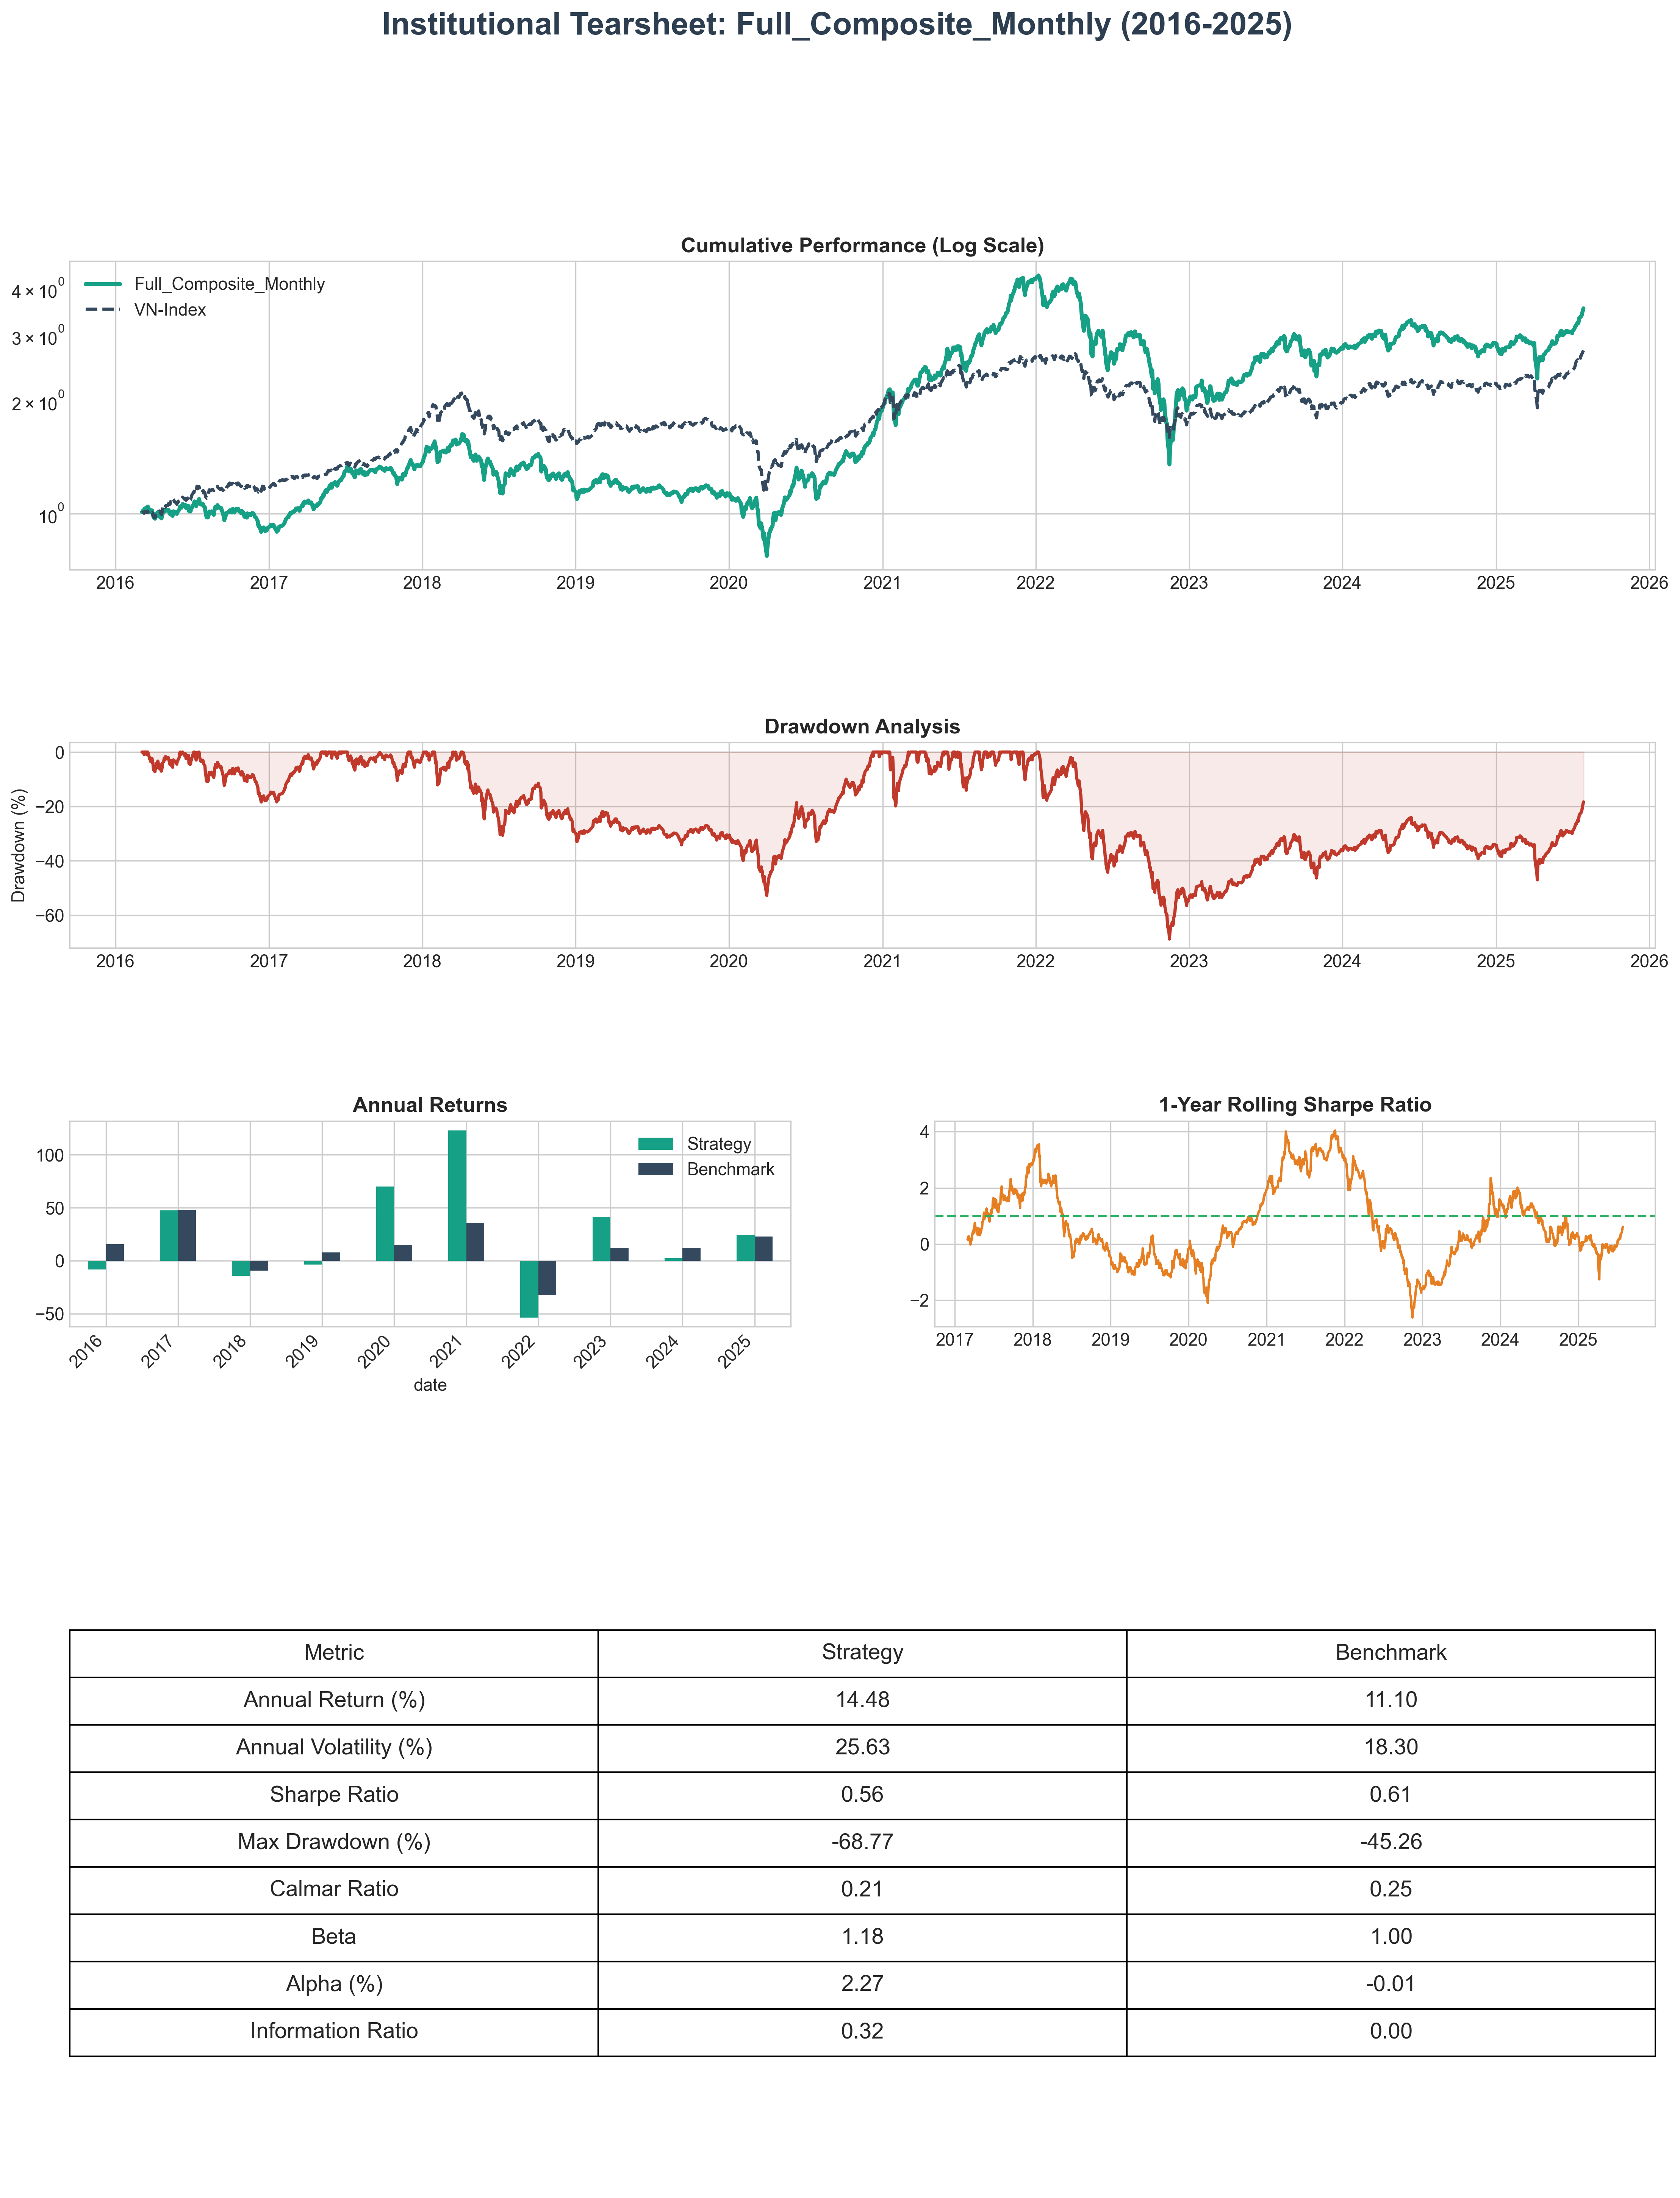

In [6]:
# ============================================================================
# DAY 4 (FULL RUN): MONTHLY FOUR-FACTOR COMPOSITE (v2 - Corrected)
# ============================================================================

# --- 1. Define Standalone Utility Functions ---
# This prevents scope errors by making functions independent of any class.

def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series) -> Dict:
    """Calculates a comprehensive set of institutional-grade performance metrics."""
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    common_index = returns.loc[first_trade_date:].index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = ((1 + returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    excess_returns = returns - benchmark
    information_ratio = (excess_returns.mean() * 252) / (excess_returns.std() * np.sqrt(252)) if excess_returns.std() > 0 else 0
    beta = np.cov(returns.fillna(0), benchmark.fillna(0))[0, 1] / np.var(benchmark.fillna(0))
    alpha = (returns.mean() - beta * benchmark.mean()) * 252
    return {'Annual Return (%)': annual_return*100, 'Annual Volatility (%)': annual_vol*100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown*100, 'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Alpha (%)': alpha*100, 'Information Ratio': information_ratio}

def generate_final_tearsheet(strategy_returns, benchmark_returns, config, palette):
    """Generates the final, institutional tearsheet."""
    # CORRECTED: Calls the standalone metrics function
    metrics = calculate_performance_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, benchmark_returns)
    
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    strategy_cum = (1 + strategy_returns.loc[first_trade_date:]).cumprod()
    benchmark_cum = (1 + benchmark_returns.loc[first_trade_date:]).cumprod()
    
    fig = plt.figure(figsize=(18, 22))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2)
    title = f"Institutional Tearsheet: {config['strategy_name']} ({first_trade_date.year}-{strategy_returns.index.max().year})"
    fig.suptitle(title, fontsize=20, fontweight='bold', color=palette['text'])

    ax1 = fig.add_subplot(gs[0, :]); ax1.plot(strategy_cum.index, strategy_cum, label=config['strategy_name'], color=palette['primary'], linewidth=2.5); ax1.plot(benchmark_cum.index, benchmark_cum, label='VN-Index', color=palette['secondary'], linestyle='--', linewidth=2); ax1.set_yscale('log'); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.legend(loc='upper left')
    ax2 = fig.add_subplot(gs[1, :]); strategy_dd = (strategy_cum / strategy_cum.cummax() - 1) * 100; ax2.plot(strategy_dd.index, strategy_dd, color=palette['negative'], linewidth=2); ax2.fill_between(strategy_dd.index, strategy_dd, 0, color=palette['negative'], alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)')
    plot_row = 2
    ax3 = fig.add_subplot(gs[plot_row, 0]); strat_annual = strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=[palette['primary'], palette['secondary']]); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold')
    ax4 = fig.add_subplot(gs[plot_row, 1]); rolling_sharpe = (strategy_returns.rolling(252).mean() * 252) / (strategy_returns.rolling(252).std() * np.sqrt(252)); ax4.plot(rolling_sharpe.index, rolling_sharpe, color=palette['highlight_2']); ax4.axhline(1.0, color=palette['positive'], linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold')
    ax5 = fig.add_subplot(gs[plot_row+1:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
    for key in metrics.keys(): summary_data.append([key, f"{metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

# --- 2. Define the Configuration for the Full Composite Run ---
print("⚙️  Defining configuration for the full four-factor monthly composite strategy...")
full_composite_config = {
    **BASE_CONFIG,
    "strategy_name": "Full_Composite_Monthly",
    "rebalance_frequency": "M",
    "factor_weights": {
        'Value_Composite': 0.45,
        'Quality_Composite': 0.20,
        'PosMom': 0.25,
        'Reversal': 0.10
    },
    "construction_method": "hybrid",
    "portfolio_size_small_universe": 20,
    "selection_percentile": 0.8
}
print("✅ Configuration for the full composite run is ready.")

# --- 3. Execute the Backtest ---
print("\n" + "="*80)
print(f"🚀 LAUNCHING DAY 4 RUN: {full_composite_config['strategy_name']}")
print("="*80)

# Instantiate the v4.1 engine
# (Ensure PortfolioEngine_v4_1 class is defined in a cell above)
full_composite_backtester = PortfolioEngine_v4_1(
    config=full_composite_config,
    factor_data=factor_data_raw,
    returns_matrix=daily_returns_matrix,
    adtv_matrix=daily_adtv_matrix,
    benchmark_returns=benchmark_returns,
    db_engine=engine,
    palette=PALETTE
)

# Run the backtest
full_composite_returns = full_composite_backtester.run()

# --- 4. Generate the Final Tearsheet ---
print("\n--- Generating Final Tearsheet for the Full Composite Strategy ---")
generate_final_tearsheet(full_composite_returns, benchmark_returns, full_composite_config, PALETTE)